In [8]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
from numpy import genfromtxt
import scipy.misc
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers import advanced_activations
from keras.layers.normalization import BatchNormalization
from keras.optimizers import *
from keras.layers.advanced_activations import *
from keras.regularizers import l2
from keras.callbacks import *
import csv
import pickle
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.externals import joblib
from skimage.transform import rotate
from skimage.util import random_noise

In [9]:
IMAGE_WIDTH = 96
IMAGE_HIGHT = 96
CHANNELS_NUM = 1
DATASET_SIZE = 7049
CLASSES_NUM = 6*2
EPOCHS_NUM = 500
BATCH_SIZE = 16
LEARNING_RATE = 0.005
FTRAIN = 'CSVs/facial_points_training.csv'
FTEST = 'CSVs/facial_points_test.csv'
FLOOKUP = 'CSVs/facial_points_IdLookupTable.csv'

In [12]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

       
def make_submission(test_labels):
    test_labels *= 48.0
    test_labels += 48.0
    test_labels = test_labels.clip(0, 96)

    lookup_table = pd.read_csv(FLOOKUP)
    values = []

    cols = joblib.load('cols.pkl')

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            test_labels[row.ImageId - 1][np.where(cols == row.FeatureName)[0][0]],
            ))
    submission = pd.DataFrame(values, columns=('RowId', 'Location'))
    submission.to_csv('CSVs/submission.csv', index=False)
    
def load(test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)  
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    if cols:  
        df = df[list(cols) + ['Image']]
    cols_l = df.columns[:-1]
    print(df.count())  
    df = df.dropna()
    X = np.vstack(df['Image'].values)  
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
        joblib.dump(cols_l, 'cols.pkl', compress=3)
    else:
        y = None
    return X, y

def augment_rotate(X, y):
    rotated_X = np.zeros_like(X)
    rotated_y = np.zeros_like(y)
    for i in range(X.shape[0]):
        img = X[i].reshape((96,96))/255.0
        labels = y[i]
        angle = np.random.randint(low=-10, high=10) * (np.pi/180.0)
        for j in np.arange(0, labels.shape[0], 2):
            R = np.sqrt(labels[j]**2 + labels[j+1]**2)
            theta = np.arctan2(labels[j+1], labels[j])
            rotated_y[i][j] = R * np.cos(theta - angle)
            rotated_y[i][j+1] = R * np.sin(theta - angle)
        rotated_X[i] = rotate(img, angle*(180/np.pi)).reshape((96*96,)) * 255
    return rotated_X, rotated_y

def augment_flip (x, y):
    for i in range (x.shape[0]):
        x[i]=np.fliplr(x[i].reshape(96,96)).reshape((96*96))
    ran = range(0,y.shape[1],2)
    y[:,ran] *= -1
    return x, y

def augment_noise (x,y):
    xx=x.copy()
    yy=y.copy()
    xx=xx.reshape(-1,96,96) / 255
    yy=yy.reshape(x.shape[0],-1)
    for i in range (x.shape[0]):
        xx[i] = random_noise(xx[i], mode='gaussian', clip=True)
        xx[i] = random_noise(xx[i], mode='s&p', clip=True, amount=0.01)
    return xx.reshape(-1,9216)*255,yy

In [13]:
cols_l = ('left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 
        'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
        'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y')
cols_r = ('right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 
        'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 
        'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y')
X_r, y_r = load(cols= cols_r)
X_f, y_f = augment_flip(X_r, y_r)
X_l, y_l = load(cols= cols_l)
X_lf = np.concatenate((X_l, X_f))
y_lf = np.concatenate((y_l, y_f))
X_r, y_r = augment_rotate(X_lf, y_lf)
X_lfr = np.concatenate((X_lf, X_r))
y_lfr = np.concatenate((y_lf, y_r))
X_n, y_n = augment_noise(X_lfr, y_lfr)
X = np.concatenate((X_lfr, X_n))
y = np.concatenate((y_lfr, y_n))
X, y = shuffle(X, y, random_state=42)  # shuffle train data
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
Image                        7049
dtype: int64
left_eye_inner_corner_x     2271
left_eye_inner_corner_y     2271
left_eye_outer_corner_x     2267
left_eye_outer_corner_y     2267
left_eyebrow_inner_end_x    2270
left_eyebrow_inner_end_y    2270
left_eyebrow_outer_end_x    2225
left_eyebrow_outer_end_y    2225
mouth_left_corner_x         2269
mouth_left_corner_y         2269
mouth_center_top_lip_x      2275
mouth_center_top_lip_y      2275
Image                       7049
dtype: int64
X.shape == (17624, 9216); X.min == 0.000; X.max == 255.000
y.shape == (17624, 12); y.min == -0.827; y.m

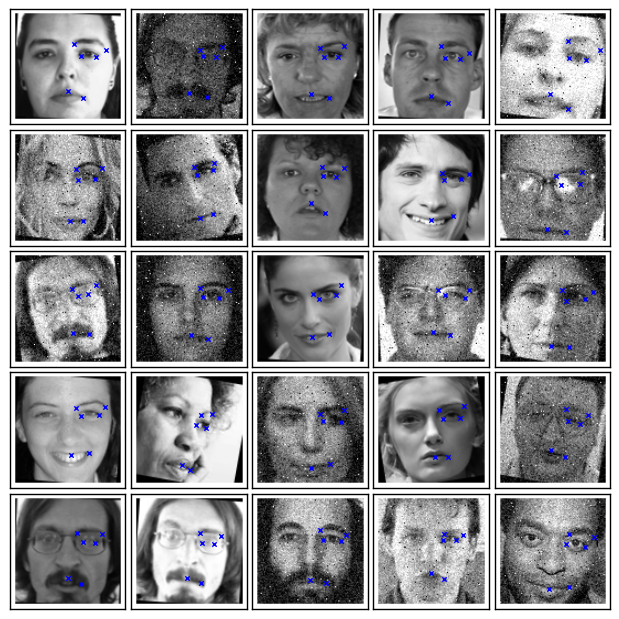

In [14]:
X_=X.reshape((-1,96,96,1))

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_sample(X_[i+30], y[i+30], ax)

plt.show()

In [15]:
def build_model():
    model = Sequential()
    
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same',
                            input_shape=(IMAGE_HIGHT, IMAGE_WIDTH, CHANNELS_NUM)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(32, 3, 3, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Convolution2D(16, 1, 1, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
        
    model.add(Convolution2D(8, 1, 1, init = 'he_normal', W_regularizer = l2(1e-4), border_mode='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(64, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))
    
    model.add(Dense(32, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.15))
    model.add(Dropout(0.3))

    model.add(Dense(CLASSES_NUM, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(Activation('linear'))
    return model

In [16]:
inzeption = build_model()
inzeption.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 96, 96, 16)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 96, 96, 16)    32          convolution2d_1[0][0]            
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 96, 96, 16)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 96, 96, 16)    0           leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [ ]:
adam = Adam(lr=LEARNING_RATE, decay=0.0005)
inzeption.compile(optimizer=adam, loss='mse', metrics=['accuracy'])
callbacks_list = [ModelCheckpoint('checkpoints/facial_points{epoch:02d}.h5', monitor='val_loss', verbose=0, save_best_only=True,
                                  save_weights_only=False, mode='auto')]

try:
    inzeption.fit(X.reshape(-1, 96, 96, 1), y, batch_size=64, nb_epoch=100, validation_split= 0.1,
                  callbacks = callbacks_list, shuffle=True)
except KeyboardInterrupt:
    pass

In [18]:
inzeption.save('my_5th_model.h5')

In [ ]:
# inzeption = load_model('checkpoints/facial_points08-0.00.h5')

ImageId    1783
Image      1783
dtype: int64


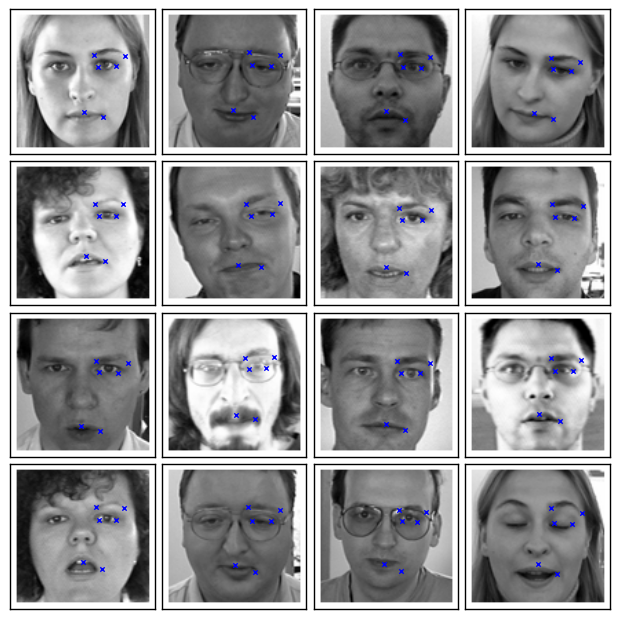

In [19]:
X_t, _ = load(test=True)
X_t=X_t.reshape((-1,96,96,1))
y_pred = inzeption.predict(X_t)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(
left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_t[i+20], y_pred[i+20], ax)

plt.show()
np.savetxt('y_pred.out', y_pred, delimiter=',') 

In [ ]:
tst = load(test=True)[0].reshape(-1, 96, 96, 1)
y_pred1 = inzeption.predict(tst)
print y_pred1.shape, tst.shape
make_submission(y_pred1)